In [1]:
from tqdm.auto import tqdm
import sympy
sympy.init_printing()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas
import control
import tclab
%matplotlib inline
import scipy
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy.optimize
import scipy.signal
from tbcontrol import blocksim
s = control.tf([1, 0], 1)
import tbcontrol
tbcontrol.expectversion('0.1.3')

In [13]:
K = 0.6423 # Data from part 1
τ = 150.312
θ = 17.397

In [14]:
def setpoint(t):
    if t < 500:
        return 35
    else:
        return 50
    
def disturbance(t):
    if t < 800:
        return 0
    else:
        return 35

# Continuous

In [177]:
def continuous(Kc, tau_i, tau_d, alpha, tspan, controllertype, filename):
    if 'I' in controllertype:
        Gc = Kc*(1 + 1/(tau_i*s) + tau_d*s/(alpha*tau_d*s + 1))
    else:
        Gc = Kc*(1 + tau_d*s/(alpha*tau_d*s + 1))    

    # simulate zero-error run to get initial state vector
    T, yout, xout = control.forced_response(Gc, [0, 1], None, transpose=True)

    # get initial state vector
    xc = xout[-1]

    steptime = 1
    totaltime = tspan + 200

    times = np.arange(0, totaltime, steptime)

    with tclab.TCLabModel(synced=False) as lab:  # change to TCLab for real
        historian = tclab.Historian(lab.sources)

        prev_t = 0

        error = setpoint(0) - lab.T1

        for t in tqdm(times):  # change to tclab.clock(steptime=steptime) to sync with time
            # Figure out how much time has gone by since previous clock tick
            # Note in the simulation case this will always be `steptime`, but when we sync
            # it may not be, so we have to calculate correctly
            Δt = t - prev_t
            prev_t = t
            bias = (setpoint(t) - 25)/0.85

            # integrate controller assuming error stays constant over timestep (zero-order-hold)
            # notice we're using the error from the previous time step, 
            # because we're simulating from one step ago to right now.
            _, yout, xout = control.forced_response(Gc, [0, Δt], [error, error], xc, transpose=True)

            controller_output = yout[-1]  + bias
            xc = xout[-1]

            # communicate with tclab
            # We read the error at "the same time" as we write
            # This ensures that the controller uses only information from the previous time step
            error = setpoint(t) - lab.T1

            # write out to tclab
            lab.Q2(disturbance(t))
            lab.Q1(controller_output)

            # update historian
            historian.update(t)
            lab.update(t)  # for the real lab this is not required

    historian.to_csv(filename)

In [181]:
Kc = 11.01
tau_i = 207.34
tau_d = 7.29
alpha = 0.1
continuous(Kc, tau_i, tau_d, alpha, tspan, 'PID', 'cont_IAE_PID.csv')

TCLab version 0.4.9
Simulated TCLab



TCLab Model disconnected successfully.


In [182]:
Kc = 7.56
tau_i = 152.97
tau_d = 0
alpha = 0.1
continuous(Kc, tau_i, tau_d, alpha, tspan, 'PI', 'cont_IAE_PI.csv')

TCLab version 0.4.9
Simulated TCLab



TCLab Model disconnected successfully.


In [183]:
Kc = 18.55
tau_i = 41.49
tau_d = 6.3
alpha = 0.1
continuous(Kc, tau_i, tau_d, alpha, tspan, 'PID', 'cont_CC_PID.csv')

TCLab version 0.4.9
Simulated TCLab



TCLab Model disconnected successfully.


In [184]:
Kc = 12.24
tau_i = 46.58
tau_d = 0
continuous(Kc, tau_i, tau_d, alpha, tspan, 'PI', 'cont_CC_PI.csv')

TCLab version 0.4.9
Simulated TCLab



TCLab Model disconnected successfully.


# Position form

In [151]:
def position_form(Kc, τI, τD, Δt, connect, tspan, controller, filename):  
    
    TCLab = tclab.setup(connected=connect, speedup=100)
    with TCLab() as lab:
        h = tclab.Historian(lab.sources)
        plot = tclab.Plotter(h, tspan)
        
        esum, ek_1, ek = 0, 0, 0
        
        if controller == 'PID':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - lab.T1
                esum += ek
                pk = bias + Kc*(ek + (Δt/τI)*esum + (τD/Δt)*(ek - ek_1))
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
       
        elif controller == 'PI':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - lab.T1
                esum += ek
                pk = bias + Kc*(ek + (Δt/τI)*esum)
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
        
        elif controller == 'P':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - lab.T1
                esum += ek
                pk = bias + Kc*(ek)
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
                lab.update(t) 
       
        h.to_csv(filename)

#### PID (CC - setpoint)

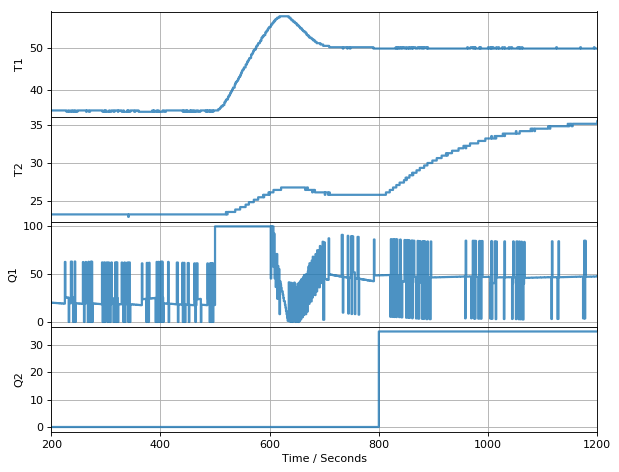

TCLab Model disconnected successfully.


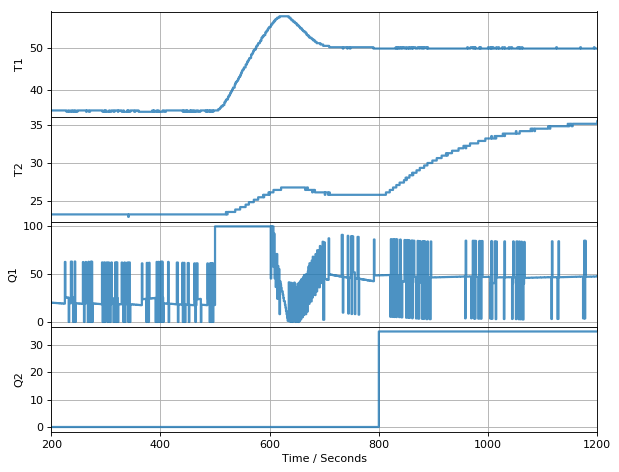

In [153]:
Kc = 18.55
τ_I = 41.49
τ_d = 6.3
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'CC_discrete_PID.csv')

#### PI (CC - setpoint)

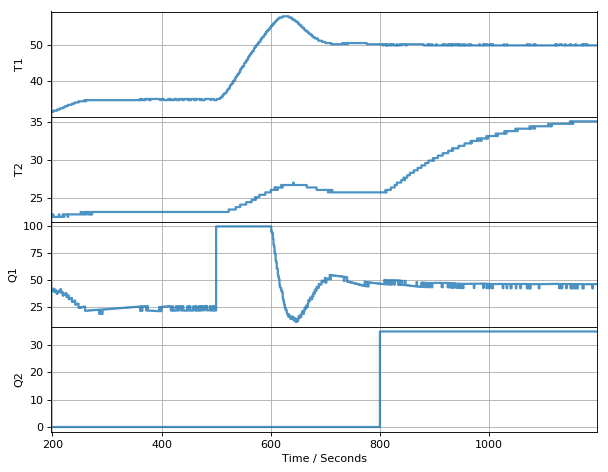

TCLab Model disconnected successfully.


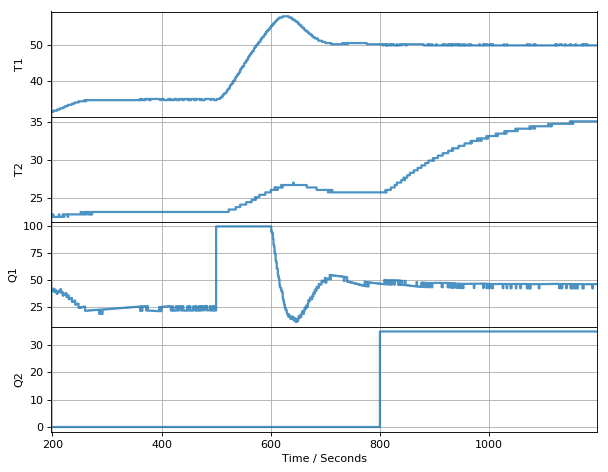

In [154]:
Kc = 12.24
τ_I = 46.58
τ_d = 0
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PI', 'CC_discrete_PI.csv')

#### P (CC - setpoint)

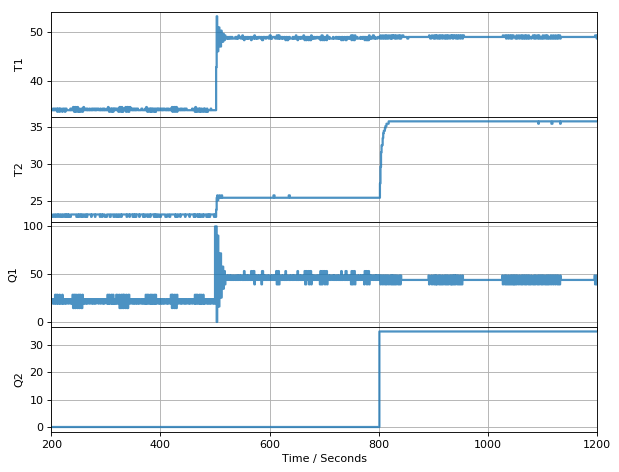

TCLab Model disconnected successfully.


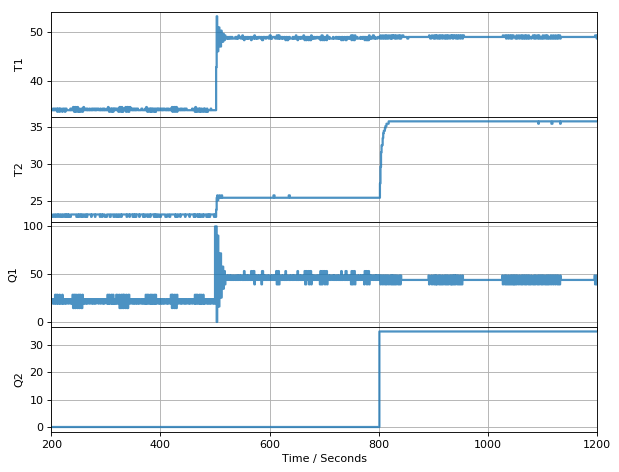

In [155]:
Kc = 14.4
τ_I = 0
τ_d = 0
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'P', 'CC_discrete_P.csv')

#### PID (IAE - setpoint)

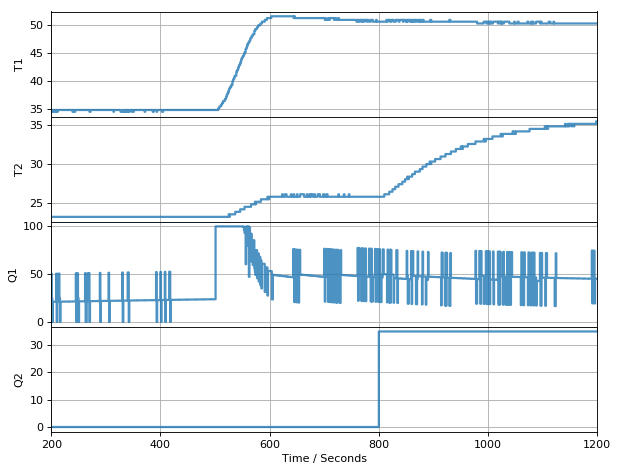

TCLab Model disconnected successfully.


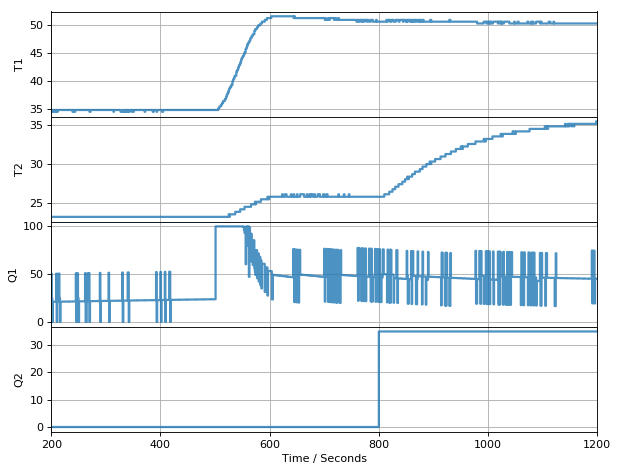

In [156]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'IAE_discrete_PID.csv')

#### PI (IAE - setpoint)

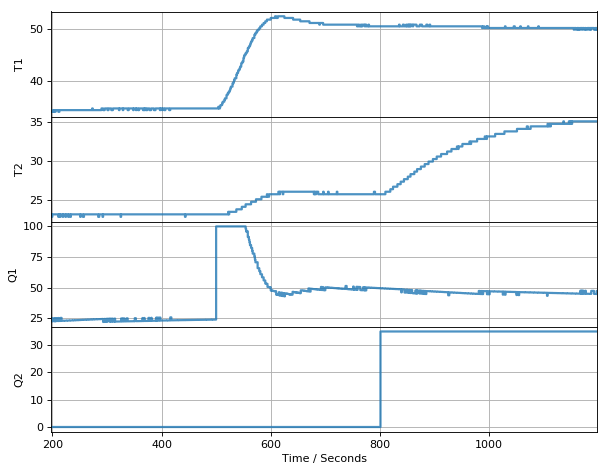

TCLab Model disconnected successfully.


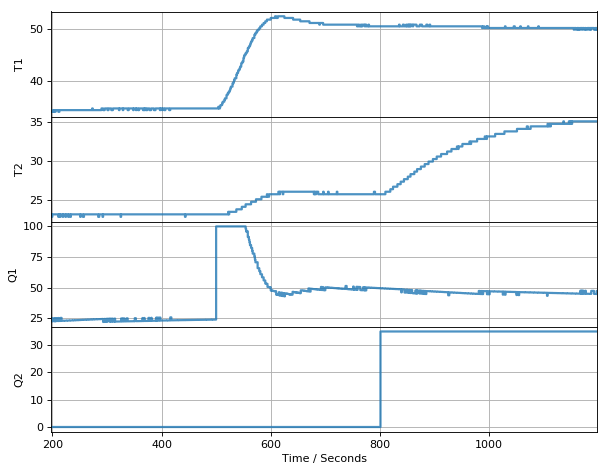

In [157]:
Kc = 7.56
τ_I = 152.97
τ_d = 0
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PI', 'IAE_discrete_PI.csv')

#### P (IAE - setpoint)

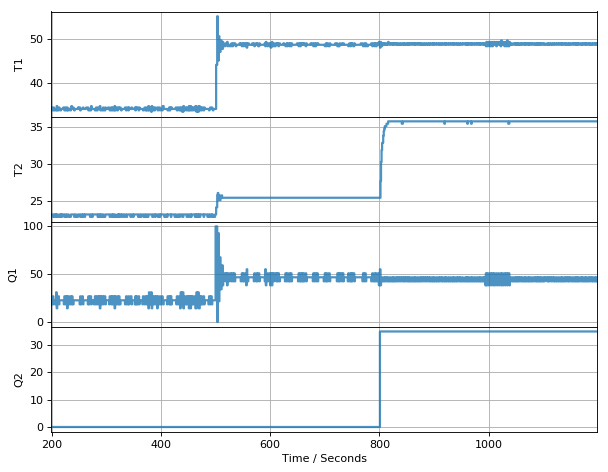

TCLab Model disconnected successfully.


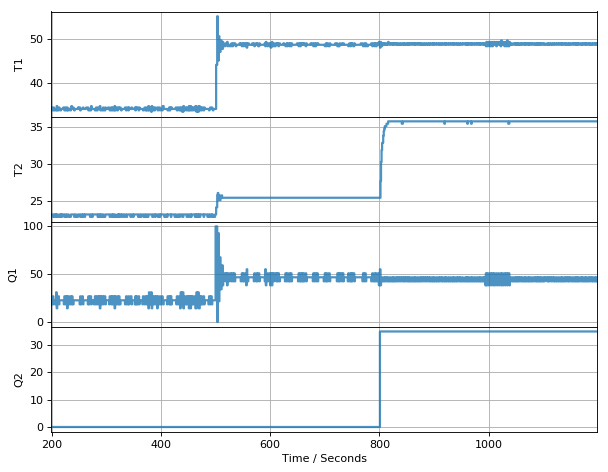

In [158]:
Kc = 13
τ_I = 0
τ_d = 0
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'P', 'IAE_discrete_P.csv')

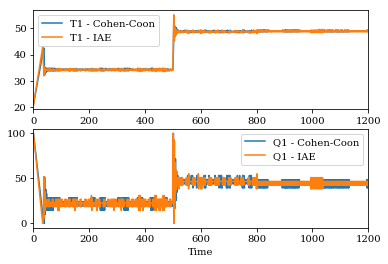

In [278]:
CC_P = pandas.read_csv('CC_discrete_P.csv').set_index('Time')
IAE_P = pandas.read_csv('IAE_discrete_P.csv').set_index('Time')
fig, (axtemp, axheat) = plt.subplots(2, 1)
CC_P[['T1']].rename(columns={'T1': 'T1 - Cohen-Coon'}).plot(ax=axtemp)
IAE_P[['T1']].rename(columns={'T1': 'T1 - IAE'}).plot(ax=axtemp)
CC_P[['Q1']].rename(columns={'Q1': 'Q1 - Cohen-Coon'}).plot(ax=axheat)
IAE_P[['Q1']].rename(columns={'Q1': 'Q1 - IAE'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Discrete_P_Comparison.pdf', format='pdf')

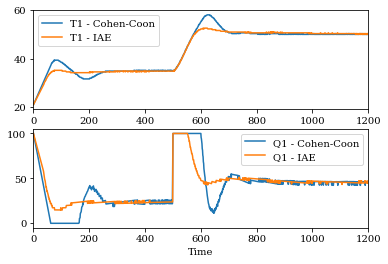

In [277]:
CC_PI = pandas.read_csv('CC_discrete_PI.csv').set_index('Time')
IAE_PI = pandas.read_csv('IAE_discrete_PI.csv').set_index('Time')
fig, (axtemp, axheat) = plt.subplots(2, 1)
CC_PI[['T1']].rename(columns={'T1': 'T1 - Cohen-Coon'}).plot(ax=axtemp)
IAE_PI[['T1']].rename(columns={'T1': 'T1 - IAE'}).plot(ax=axtemp)
CC_PI[['Q1']].rename(columns={'Q1': 'Q1 - Cohen-Coon'}).plot(ax=axheat)
IAE_PI[['Q1']].rename(columns={'Q1': 'Q1 - IAE'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Discrete_PI_Comparison.pdf', format='pdf')

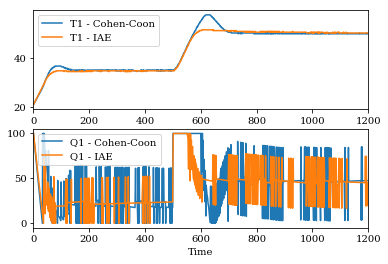

In [276]:
CC_PID = pandas.read_csv('CC_discrete_PID.csv').set_index('Time')
IAE_PID = pandas.read_csv('IAE_discrete_PID.csv').set_index('Time')
fig, (axtemp, axheat) = plt.subplots(2, 1)
CC_PID[['T1']].rename(columns={'T1': 'T1 - Cohen-Coon'}).plot(ax=axtemp)
IAE_PID[['T1']].rename(columns={'T1': 'T1 - IAE'}).plot(ax=axtemp)
CC_PID[['Q1']].rename(columns={'Q1': 'Q1 - Cohen-Coon'}).plot(ax=axheat)
IAE_PID[['Q1']].rename(columns={'Q1': 'Q1 - IAE'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Discrete_PID_Comparison.pdf', format='pdf')

# Velocity form

In [164]:
def velocity_form(Kc, τI, τD, Δt, connect, tspan, controller, filename):  
    
    TCLab = tclab.setup(connected=connect, speedup = 100)
    with TCLab() as lab:
        h = tclab.Historian(lab.sources)
        plot = tclab.Plotter(h, tspan)
        
        ek = ek_1 = ek_2 = 0
        if controller == 'PID':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = 1/0.85*(setpoint(t) - 25)
                ek = setpoint(t) - lab.T1

                Δpk = Kc*((ek - ek_1) + (Δt/τI)*ek + (τD/Δt)*(ek - 2*ek_1 + ek_2))
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
        if controller == 'PI':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - lab.T1

                Δpk = Kc*((ek - ek_1) + (Δt/τI)*ek)
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
        if controller == 'P':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - lab.T1

                Δpk = Kc*((ek - ek_1))
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
            
    h.to_csv(filename)

#### PID (CC - setpoint)

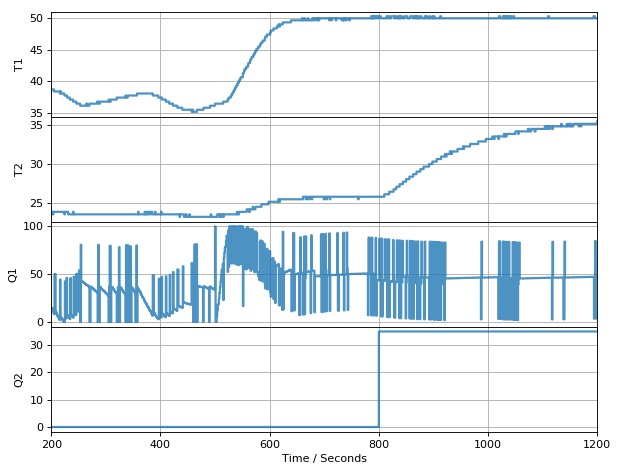

TCLab Model disconnected successfully.


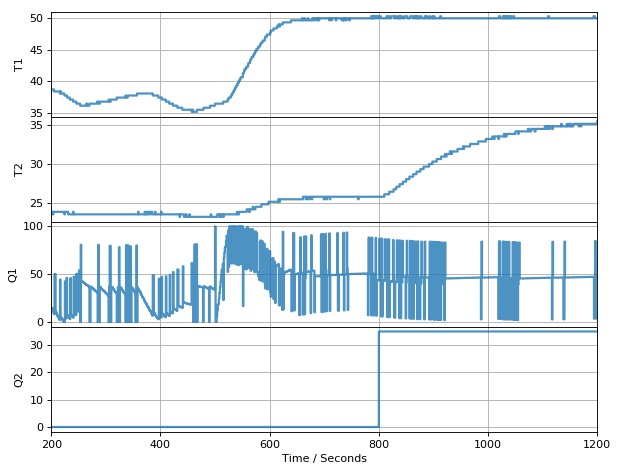

In [165]:
Kc = 18.55
τ_I = 41.49
τ_d = 6.3
Δt = 1
tspan = 1000
velocity_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'CC_discrete_PID_vf.csv')

#### PI (CC - setpoint)

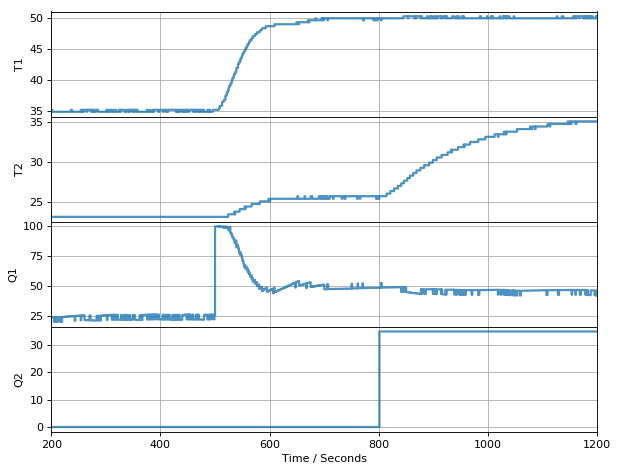

TCLab Model disconnected successfully.


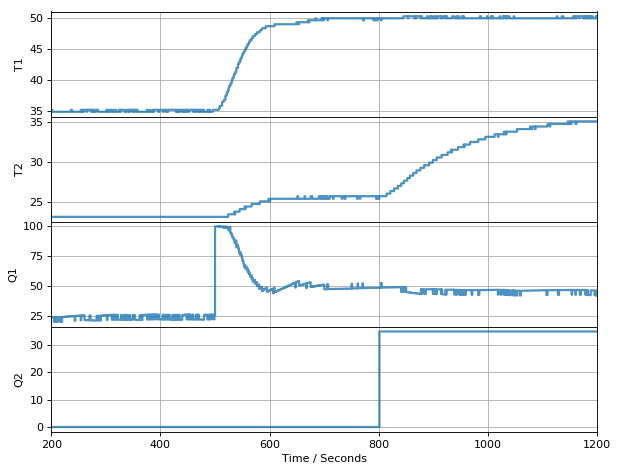

In [166]:
Kc = 12.24
τ_I = 46.58
τ_d = 0
Δt = 1
tspan = 1000
velocity_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PI', 'CC_discrete_PI_vf.csv')

#### P (CC - setpoint)

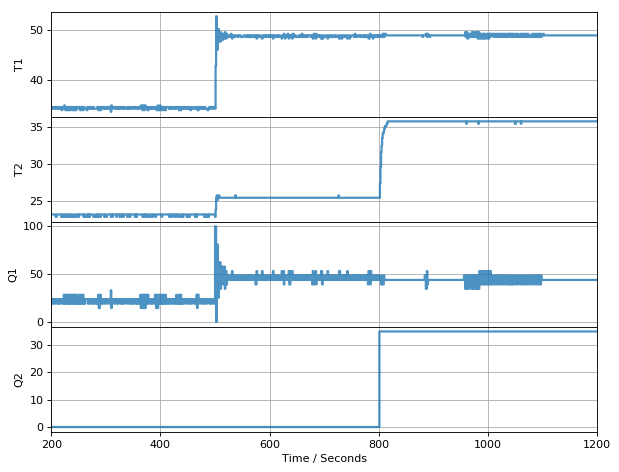

TCLab Model disconnected successfully.


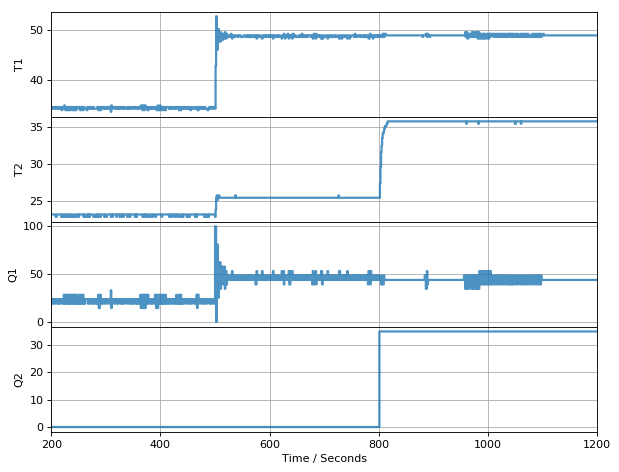

In [167]:
Kc = 14.4
τ_I = 0
τ_d = 0
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'P', 'CC_discrete_P_vf.csv')

#### PID (IAE - setpoint)

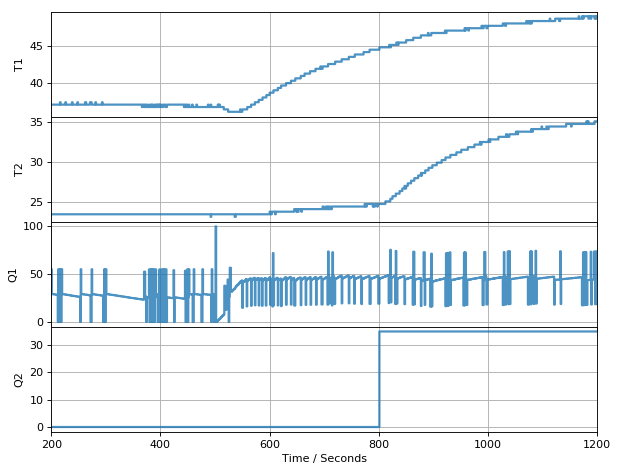

TCLab Model disconnected successfully.


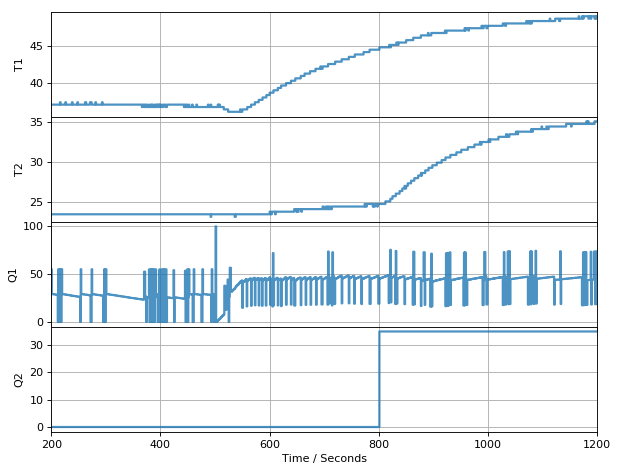

In [168]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 1000
velocity_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'IAE_discrete_PID_vf.csv')

#### PI (IAE - setpoint)

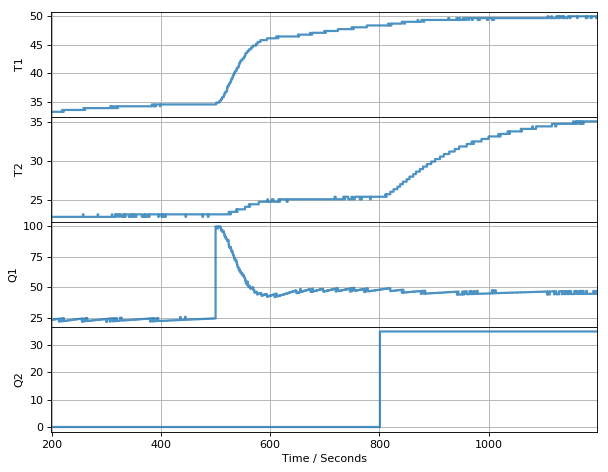

TCLab Model disconnected successfully.


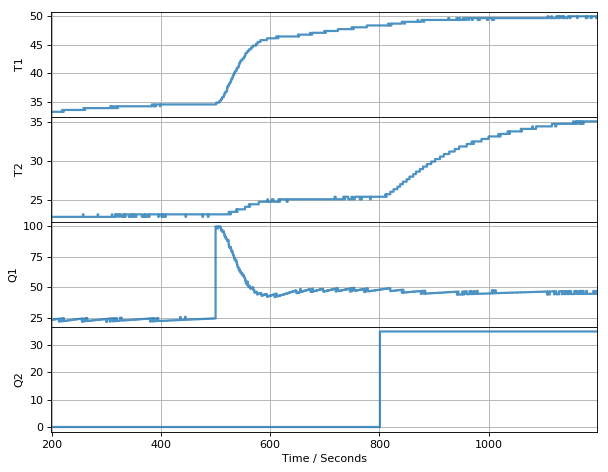

In [169]:
Kc = 7.56
τ_I = 152.97
τ_d = 0
Δt = 1
tspan = 1000
velocity_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PI', 'IAE_discrete_PI_vf.csv')

#### P (IAE - setpoint)

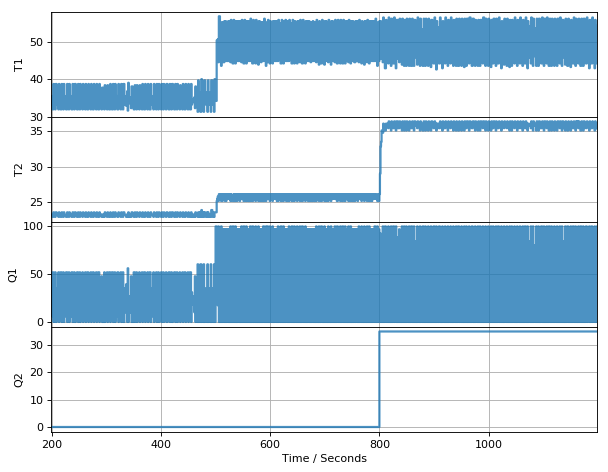

TCLab Model disconnected successfully.


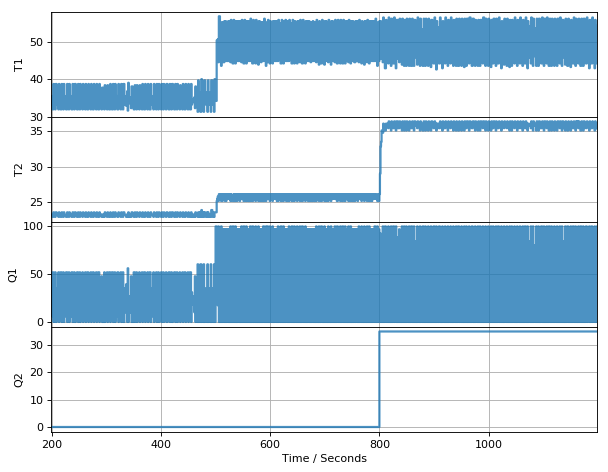

In [170]:
Kc = 13
τ_I = 0
τ_d = 0
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'P', 'IAE_discrete_P_vf.csv')

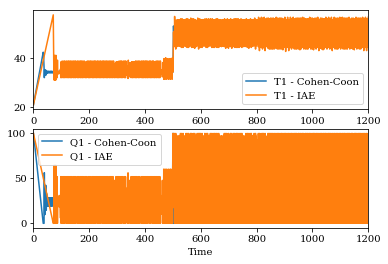

In [275]:
CC_P = pandas.read_csv('CC_discrete_P_vf.csv').set_index('Time')
IAE_P = pandas.read_csv('IAE_discrete_P_vf.csv').set_index('Time')
fig, (axtemp, axheat) = plt.subplots(2, 1)
CC_P[['T1']].rename(columns={'T1': 'T1 - Cohen-Coon'}).plot(ax=axtemp)
IAE_P[['T1']].rename(columns={'T1': 'T1 - IAE'}).plot(ax=axtemp)
CC_P[['Q1']].rename(columns={'Q1': 'Q1 - Cohen-Coon'}).plot(ax=axheat)
IAE_P[['Q1']].rename(columns={'Q1': 'Q1 - IAE'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Discrete_P_Comparison_vf.pdf', format='pdf')

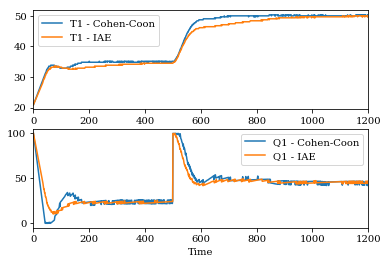

In [274]:
CC_PI = pandas.read_csv('CC_discrete_PI_vf.csv').set_index('Time')
IAE_PI = pandas.read_csv('IAE_discrete_PI_vf.csv').set_index('Time')
fig, (axtemp, axheat) = plt.subplots(2, 1)
CC_PI[['T1']].rename(columns={'T1': 'T1 - Cohen-Coon'}).plot(ax=axtemp)
IAE_PI[['T1']].rename(columns={'T1': 'T1 - IAE'}).plot(ax=axtemp)
CC_PI[['Q1']].rename(columns={'Q1': 'Q1 - Cohen-Coon'}).plot(ax=axheat)
IAE_PI[['Q1']].rename(columns={'Q1': 'Q1 - IAE'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Discrete_PI_Comparison_vf.pdf', format='pdf')

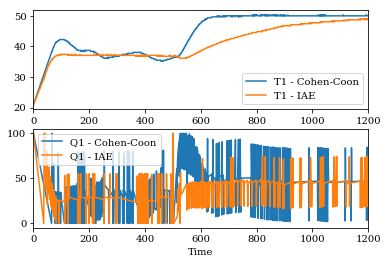

In [273]:
CC_PID = pandas.read_csv('CC_discrete_PID_vf.csv').set_index('Time')
IAE_PID = pandas.read_csv('IAE_discrete_PID_vf.csv').set_index('Time')
fig, (axtemp, axheat) = plt.subplots(2, 1)
CC_PID[['T1']].rename(columns={'T1': 'T1 - Cohen-Coon'}).plot(ax=axtemp)
IAE_PID[['T1']].rename(columns={'T1': 'T1 - IAE'}).plot(ax=axtemp)
CC_PID[['Q1']].rename(columns={'Q1': 'Q1 - Cohen-Coon'}).plot(ax=axheat)
IAE_PID[['Q1']].rename(columns={'Q1': 'Q1 - IAE'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Discrete_PID_Comparison_vf.pdf', format='pdf')

# Position vs Velocity

#### Setpoint tracking and disturbance for IAE PID discrete controllers, position vs velocity form.

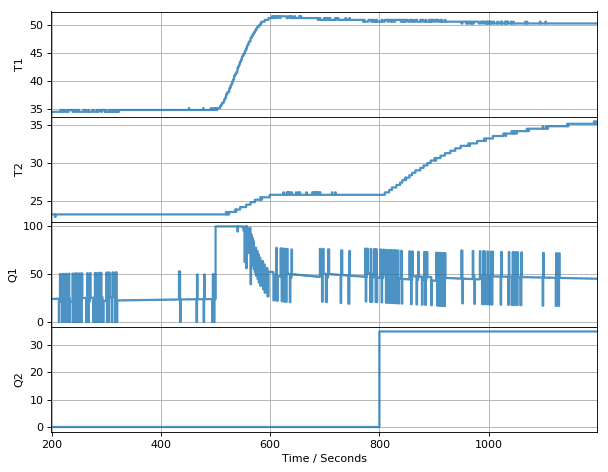

TCLab Model disconnected successfully.


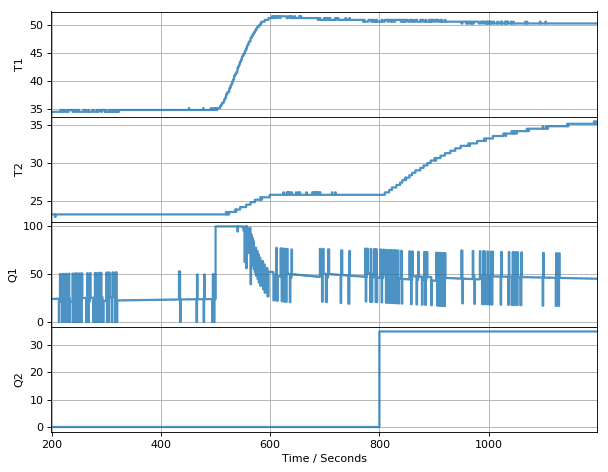

In [192]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'Position_PID_unsaturation.csv')

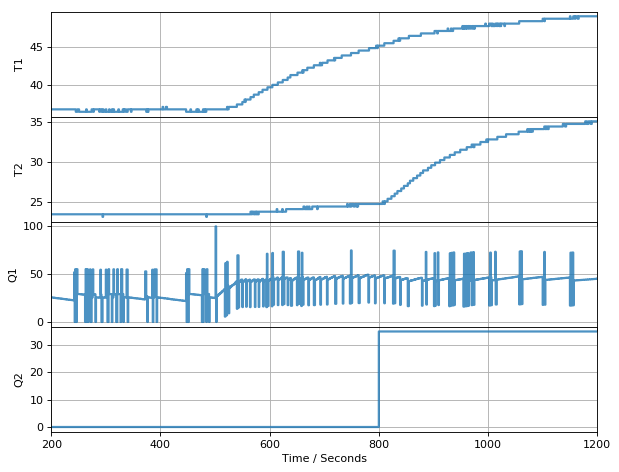

TCLab Model disconnected successfully.


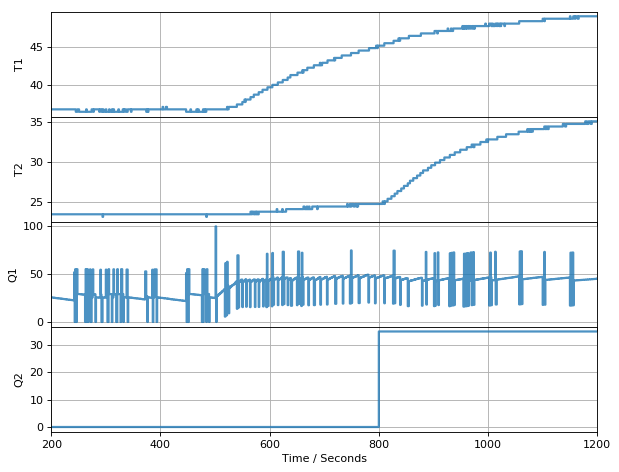

In [195]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 1000
velocity_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'Velocity_PID_unsaturation.csv')

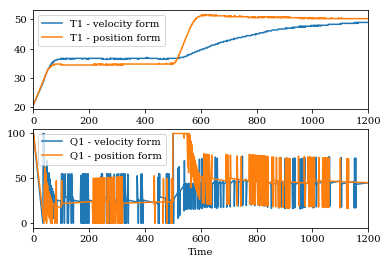

In [272]:
vf = pandas.read_csv('Velocity_PID_unsaturation.csv').set_index('Time')
pos = pandas.read_csv('Position_PID_unsaturation.csv').set_index('Time')
fig, (axtemp, axheat) = plt.subplots(2, 1)
vf[['T1']].rename(columns={'T1': 'T1 - velocity form'}).plot(ax=axtemp)
pos[['T1']].rename(columns={'T1': 'T1 - position form'}).plot(ax=axtemp)
vf[['Q1']].rename(columns={'Q1': 'Q1 - velocity form'}).plot(ax=axheat)
pos[['Q1']].rename(columns={'Q1': 'Q1 - position form'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('position_velocity_unsaturation.pdf', format='pdf')

### Saturation

In [197]:
def setpoint(t):
    if t < 800:
        return 150
    else:
        return 50
    
def disturbance(t):
    if t < 800:
        return 0
    else:
        return 0

#### Position PID IAE

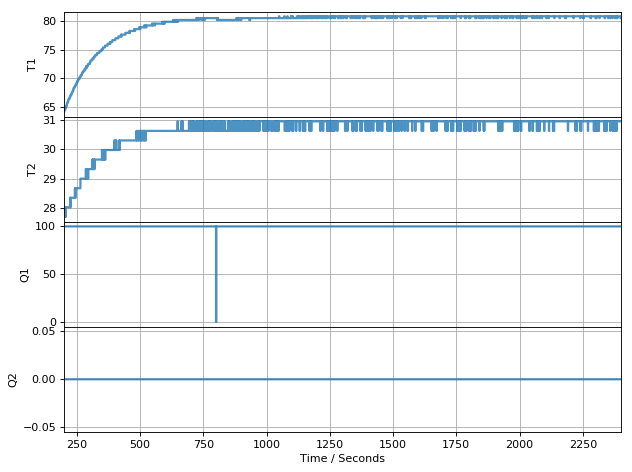

TCLab Model disconnected successfully.


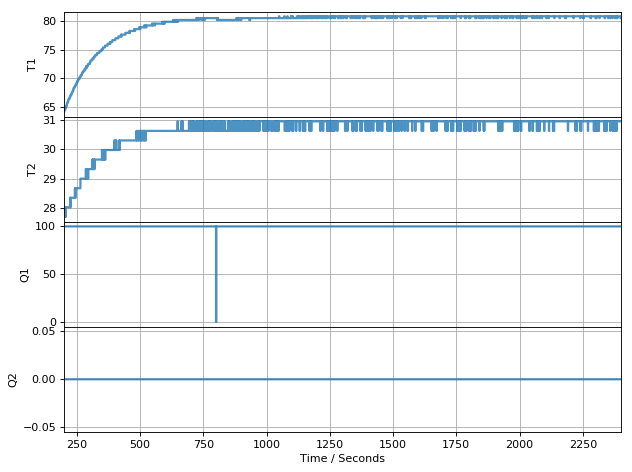

In [198]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 2200
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'Position_PID_saturation.csv')

#### Velocity PID IAE

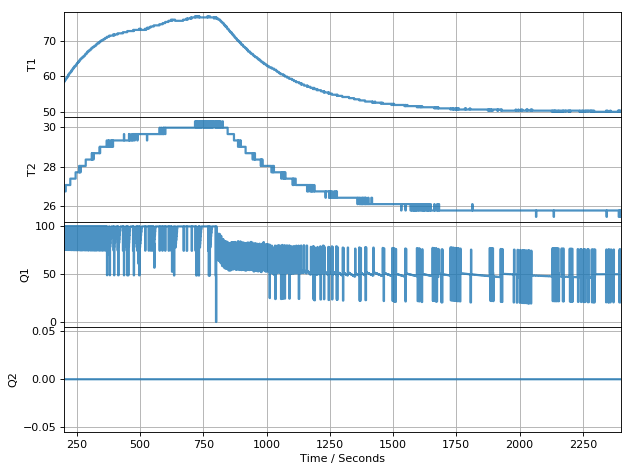

TCLab Model disconnected successfully.


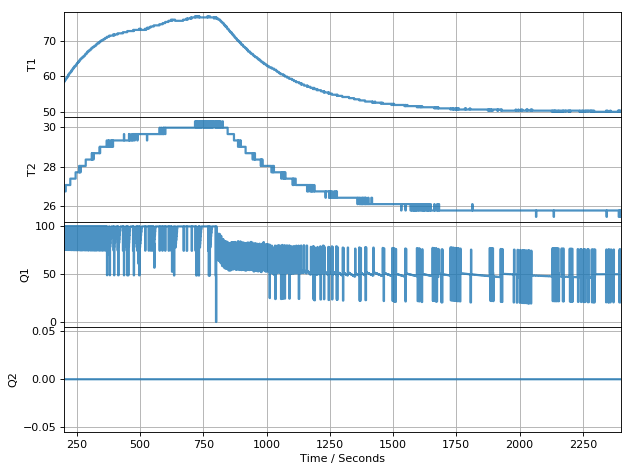

In [199]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 2200
velocity_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'Velocity_PID_saturation.csv')

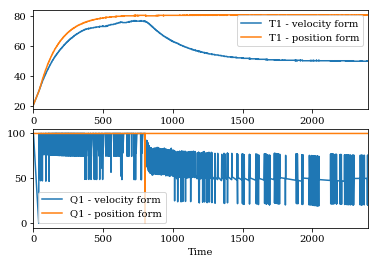

In [271]:
vf = pandas.read_csv('Velocity_PID_saturation.csv').set_index('Time')
pos = pandas.read_csv('Position_PID_saturation.csv').set_index('Time')
fig, (axtemp, axheat) = plt.subplots(2, 1)
vf[['T1']].rename(columns={'T1': 'T1 - velocity form'}).plot(ax=axtemp)
pos[['T1']].rename(columns={'T1': 'T1 - position form'}).plot(ax=axtemp)
vf[['Q1']].rename(columns={'Q1': 'Q1 - velocity form'}).plot(ax=axheat)
pos[['Q1']].rename(columns={'Q1': 'Q1 - position form'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('position_velocity_saturation.pdf', format='pdf')

# Continuous vs Discrete

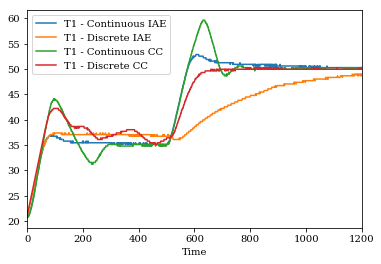

In [270]:
IAE_PID_cont = pandas.read_csv('cont_IAE_PID.csv').set_index('Time')
CC_PID_cont = pandas.read_csv('cont_CC_PID.csv').set_index('Time')
CC_PID_vf = pandas.read_csv('CC_discrete_PID_vf.csv').set_index('Time')
IAE_PID_vf = pandas.read_csv('IAE_discrete_PID_vf.csv').set_index('Time')

fig, (axtemp) = plt.subplots(1)
IAE_PID_cont[['T1']].rename(columns={'T1': 'T1 - Continuous IAE'}).plot(ax=axtemp)
IAE_PID_vf[['T1']].rename(columns={'T1': 'T1 - Discrete IAE'}).plot(ax=axtemp)
CC_PID_cont[['T1']].rename(columns={'T1': 'T1 - Continuous CC'}).plot(ax=axtemp)
CC_PID_vf[['T1']].rename(columns={'T1': 'T1 - Discrete CC'}).plot(ax=axtemp)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Cont_Disc_PID_Comparison.pdf', format='pdf')

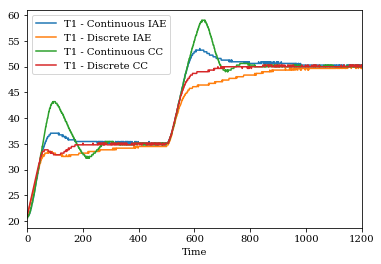

In [260]:
IAE_PI_cont = pandas.read_csv('cont_IAE_PI.csv').set_index('Time')
CC_PI_cont = pandas.read_csv('cont_CC_PI.csv').set_index('Time')
CC_PI_vf = pandas.read_csv('CC_discrete_PI_vf.csv').set_index('Time')
IAE_PI_vf = pandas.read_csv('IAE_discrete_PI_vf.csv').set_index('Time')

fig, (axtemp) = plt.subplots(1)
IAE_PI_cont[['T1']].rename(columns={'T1': 'T1 - Continuous IAE'}).plot(ax=axtemp)
IAE_PI_vf[['T1']].rename(columns={'T1': 'T1 - Discrete IAE'}).plot(ax=axtemp)
CC_PI_cont[['T1']].rename(columns={'T1': 'T1 - Continuous CC'}).plot(ax=axtemp)
CC_PI_vf[['T1']].rename(columns={'T1': 'T1 - Discrete CC'}).plot(ax=axtemp)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Cont_Disc_PI_Comparison.pdf', format='pdf')

# Noise

In [206]:
def noise(size):
    return (np.random.randn()*size)

In [235]:
def setpoint(t):
    if t < 500:
        return 35
    else:
        return 50
    
def disturbance(t):
    if t < 800:
        return 0
    else:
        return 35

##### Noise added to the continuous controller

In [241]:
def continuous_noise(Kc, tau_i, tau_d, alpha, tspan, noise_size, controllertype, filename):
    if 'I' in controllertype:
        Gc = Kc*(1 + 1/(tau_i*s) + tau_d*s/(alpha*tau_d*s + 1))
    else:
        Gc = Kc*(1 + tau_d*s/(alpha*tau_d*s + 1))    

    # simulate zero-error run to get initial state vector
    T, yout, xout = control.forced_response(Gc, [0, 1], None, transpose=True)

    # get initial state vector
    xc = xout[-1]

    steptime = 1
    totaltime = tspan + 200

    times = np.arange(0, totaltime, steptime)

    with tclab.TCLabModel(synced=False) as lab:  # change to TCLab for real
        historian = tclab.Historian(lab.sources)

        prev_t = 0

        error = setpoint(0) - (lab.T1 + noise(noise_size))

        for t in tqdm(times):  # change to tclab.clock(steptime=steptime) to sync with time
            # Figure out how much time has gone by since previous clock tick
            # Note in the simulation case this will always be `steptime`, but when we sync
            # it may not be, so we have to calculate correctly
            Δt = t - prev_t
            prev_t = t
            bias = (setpoint(t) - 25)/0.85

            # integrate controller assuming error stays constant over timestep (zero-order-hold)
            # notice we're using the error from the previous time step, 
            # because we're simulating from one step ago to right now.
            _, yout, xout = control.forced_response(Gc, [0, Δt], [error, error], xc, transpose=True)

            controller_output = yout[-1]  + bias
            xc = xout[-1]

            # communicate with tclab
            # We read the error at "the same time" as we write
            # This ensures that the controller uses only information from the previous time step
            error = setpoint(t) - (lab.T1 + noise(noise_size))

            # write out to tclab
            lab.Q2(disturbance(t))
            lab.Q1(controller_output)

            # update historian
            historian.update(t)
            lab.update(t)  # for the real lab this is not required

    historian.to_csv(filename)

In [245]:
Kc = 11.01
tau_i = 207.34
tau_d = 7.29
alpha = 0.1
noise_size = 10 #0.5, 1, 5, 10
continuous_noise(Kc, tau_i, tau_d, alpha, tspan, noise_size, 'PID', 'cont_IAE_PID_noise_'+str(noise_size)+'.csv')

TCLab version 0.4.9
Simulated TCLab



TCLab Model disconnected successfully.


##### Noise added to the velocity and position form discrete controller

In [221]:
def position_form_noise(Kc, τI, τD, Δt, connect, tspan, noise_size, controller, filename):  
    
    TCLab = tclab.setup(connected=connect, speedup=100)
    with TCLab() as lab:
        h = tclab.Historian(lab.sources)
        plot = tclab.Plotter(h, tspan)
        
        esum, ek_1, ek = 0, 0, 0
        
        if controller == 'PID':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - (lab.T1 + noise(noise_size))
                esum += ek
                pk = bias + Kc*(ek + (Δt/τI)*esum + (τD/Δt)*(ek - ek_1))
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
       
        elif controller == 'PI':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - (lab.T1 + noise(noise_size))
                esum += ek
                pk = bias + Kc*(ek + (Δt/τI)*esum)
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
        
        elif controller == 'P':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - (lab.T1 + noise(noise_size))
                esum += ek
                pk = bias + Kc*(ek)
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
                lab.update(t) 
       
        h.to_csv(filename)

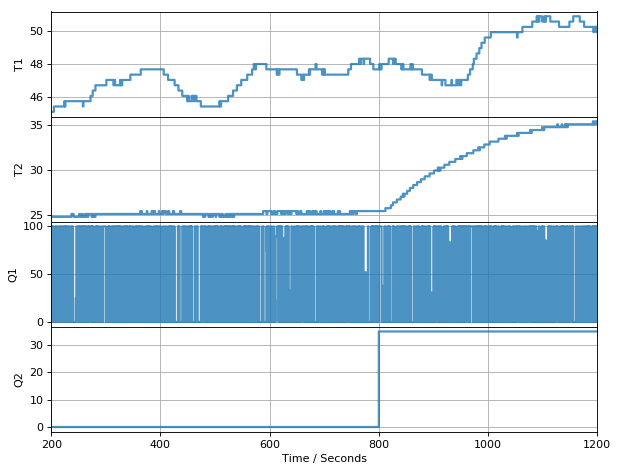

TCLab Model disconnected successfully.


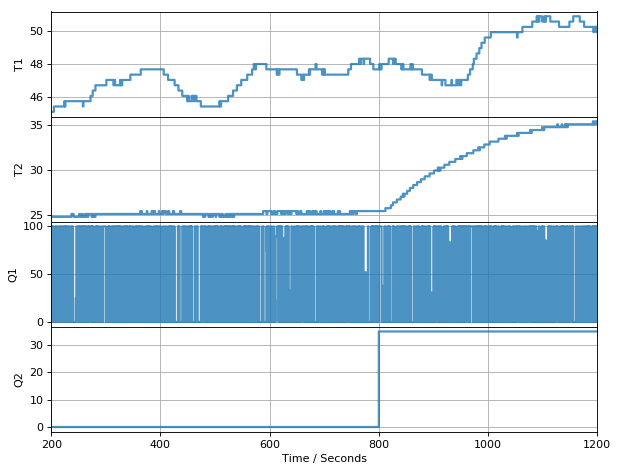

In [229]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 1000
noise_size = 10#0.5, 1, 5, 10
position_form_noise(Kc, τ_I, τ_d, Δt, False, tspan, noise_size, 'PID', 'IAE_discrete_PID_noise_pos_'+str(noise_size)+'.csv')

In [223]:
def velocity_form_noise(Kc, τI, τD, Δt, connect, tspan, noise_size, controller, filename):  
    
    TCLab = tclab.setup(connected=connect, speedup = 100)
    with TCLab() as lab:
        h = tclab.Historian(lab.sources)
        plot = tclab.Plotter(h, tspan)
        
        ek = ek_1 = ek_2 = 0
        if controller == 'PID':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - (lab.T1 + noise(noise_size))

                Δpk = Kc*((ek - ek_1) + (Δt/τI)*ek + (τD/Δt)*(ek - 2*ek_1 + ek_2))
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
        if controller == 'PI':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - (lab.T1 + noise(noise_size))

                Δpk = Kc*((ek - ek_1) + (Δt/τI)*ek)
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
        if controller == 'P':
            for t in tclab.clock(tspan+200, step=Δt):
                bias = (setpoint(t) - 25)/0.85
                ek = setpoint(t) - (lab.T1 + noise(noise_size))

                Δpk = Kc*((ek - ek_1))
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
            
    h.to_csv(filename)

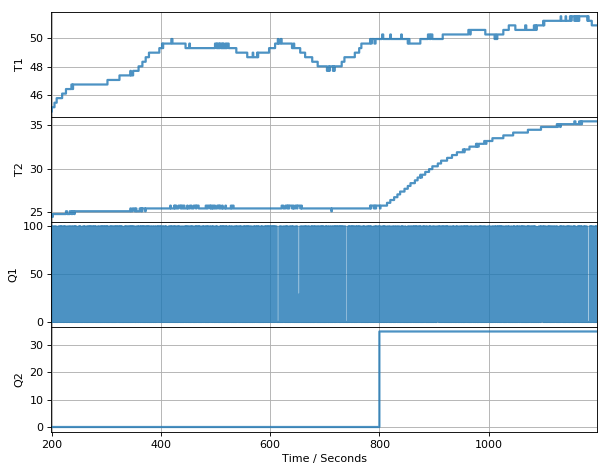

TCLab Model disconnected successfully.


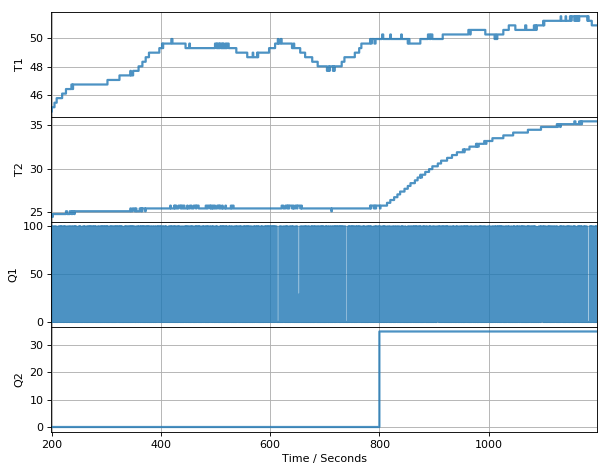

In [230]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 1000
noise_size = 10 #0.5, 1, 5, 10
velocity_form_noise(Kc, τ_I, τ_d, Δt, False, tspan, noise_size, 'PID', 'IAE_discrete_PID_noise_vf_'+str(noise_size)+'.csv')

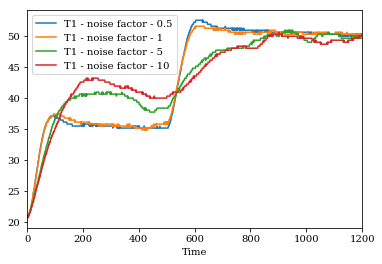

In [281]:
cont_noise_05 = pandas.read_csv('cont_IAE_PID_noise_0.5.csv').set_index('Time')
cont_noise_1 = pandas.read_csv('cont_IAE_PID_noise_1.csv').set_index('Time')
cont_noise_5 = pandas.read_csv('cont_IAE_PID_noise_5.csv').set_index('Time')
cont_noise_10 = pandas.read_csv('cont_IAE_PID_noise_10.csv').set_index('Time')



fig, (axtemp, axheat) = plt.subplots(2, 1)
cont_noise_05[['T1']].rename(columns={'T1': 'T1 - noise factor - 0.5'}).plot(ax=axtemp)
cont_noise_1[['T1']].rename(columns={'T1': 'T1 - noise factor - 1'}).plot(ax=axtemp)
cont_noise_5[['T1']].rename(columns={'T1': 'T1 - noise factor - 5'}).plot(ax=axtemp)
cont_noise_10[['T1']].rename(columns={'T1': 'T1 - noise factor - 10'}).plot(ax=axtemp)
# cont_noise_05[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 0.5'}).plot(ax=axheat)
# cont_noise_1[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 1'}).plot(ax=axheat)
# cont_noise_5[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 5'}).plot(ax=axheat)
# cont_noise_10[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 10'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Cont_noise.pdf', format='pdf')

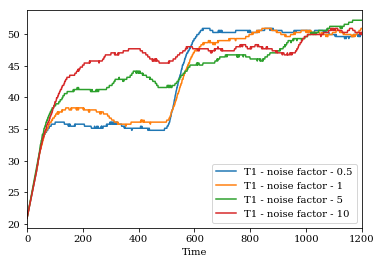

In [258]:
pos_noise_05 = pandas.read_csv('IAE_discrete_PID_noise_pos_0.5.csv').set_index('Time')
pos_noise_1 = pandas.read_csv('IAE_discrete_PID_noise_pos_1.csv').set_index('Time')
pos_noise_5 = pandas.read_csv('IAE_discrete_PID_noise_pos_5.csv').set_index('Time')
pos_noise_10 = pandas.read_csv('IAE_discrete_PID_noise_pos_10.csv').set_index('Time')


fig, (axtemp) = plt.subplots(1)
pos_noise_05[['T1']].rename(columns={'T1': 'T1 - noise factor - 0.5'}).plot(ax=axtemp)
pos_noise_1[['T1']].rename(columns={'T1': 'T1 - noise factor - 1'}).plot(ax=axtemp)
pos_noise_5[['T1']].rename(columns={'T1': 'T1 - noise factor - 5'}).plot(ax=axtemp)
pos_noise_10[['T1']].rename(columns={'T1': 'T1 - noise factor - 10'}).plot(ax=axtemp)
# pos_noise_05[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 0.5'}).plot(ax=axheat)
# pos_noise_1[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 1'}).plot(ax=axheat)
# pos_noise_5[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 5'}).plot(ax=axheat)
# pos_noise_10[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 10'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('position_noise.pdf', format='pdf')

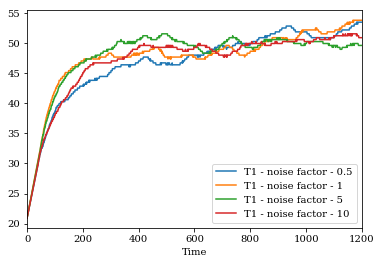

In [259]:
vf_noise_05 = pandas.read_csv('IAE_discrete_PID_noise_vf_0.5.csv').set_index('Time')
vf_noise_1 = pandas.read_csv('IAE_discrete_PID_noise_vf_1.csv').set_index('Time')
vf_noise_5 = pandas.read_csv('IAE_discrete_PID_noise_vf_5.csv').set_index('Time')
vf_noise_10 = pandas.read_csv('IAE_discrete_PID_noise_vf_10.csv').set_index('Time')

fig, (axtemp, axheat) = plt.subplots(2, 1)
vf_noise_05[['T1']].rename(columns={'T1': 'T1 - noise factor - 0.5'}).plot(ax=axtemp)
vf_noise_1[['T1']].rename(columns={'T1': 'T1 - noise factor - 1'}).plot(ax=axtemp)
vf_noise_5[['T1']].rename(columns={'T1': 'T1 - noise factor - 5'}).plot(ax=axtemp)
vf_noise_10[['T1']].rename(columns={'T1': 'T1 - noise factor - 10'}).plot(ax=axtemp)
# vf_noise_05[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 0.5'}).plot(ax=axheat)
# vf_noise_1[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 1'}).plot(ax=axheat)
# vf_noise_5[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 5'}).plot(ax=axheat)
# vf_noise_10[['Q1']].rename(columns={'Q1': 'Q1 - noise factor - 10'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('velocity_noise.pdf', format='pdf')

# Sampling rate

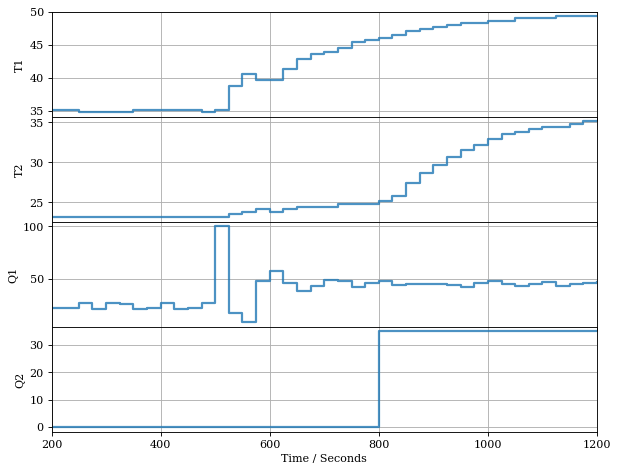

TCLab Model disconnected successfully.


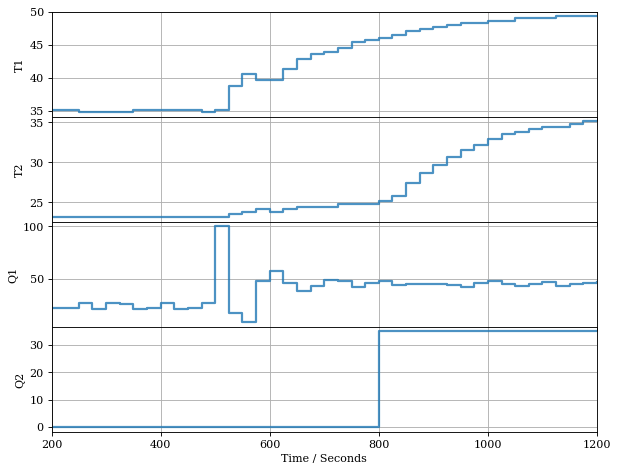

In [294]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 25 #0.1, 1, 5, 10, 25
tspan = 1000
velocity_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'Velocity_sample_rate_'+str(Δt)+'.csv')

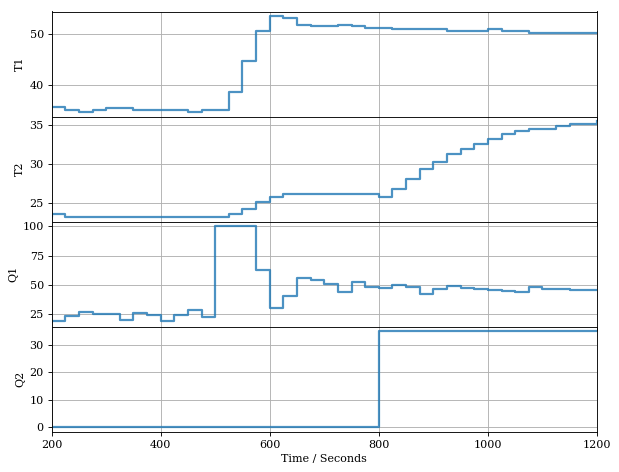

TCLab Model disconnected successfully.


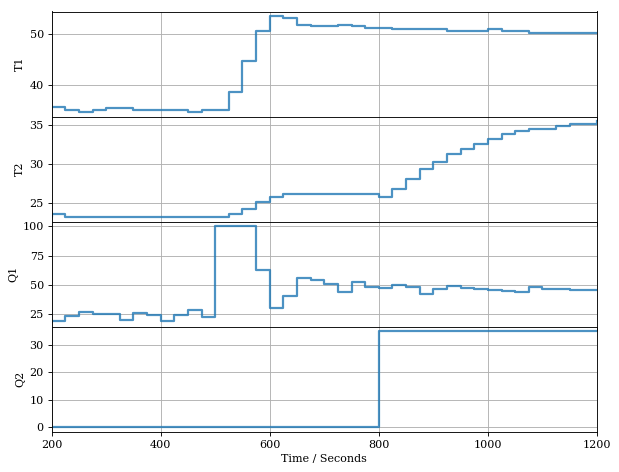

In [295]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 25 #0.1, 1, 5, 10, 25
tspan = 1000
position_form(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'Position_sample_rate_'+str(Δt)+'.csv')

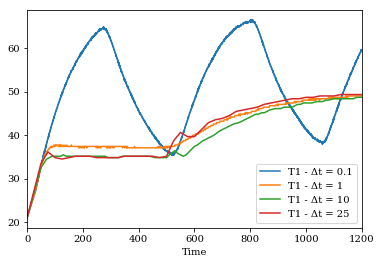

In [348]:
vf_dt_01 = pandas.read_csv('Velocity_sample_rate_0.1.csv').set_index('Time')
vf_dt_1 = pandas.read_csv('Velocity_sample_rate_1.csv').set_index('Time')
vf_dt_5 = pandas.read_csv('Velocity_sample_rate_5.csv').set_index('Time')
vf_dt_10 = pandas.read_csv('Velocity_sample_rate_10.csv').set_index('Time')
vf_dt_25 = pandas.read_csv('Velocity_sample_rate_25.csv').set_index('Time')

fig, (axtemp) = plt.subplots(1)
vf_dt_01[['T1']].rename(columns={'T1': 'T1 - Δt = 0.1'}).plot(ax=axtemp)
vf_dt_1[['T1']].rename(columns={'T1': 'T1 - Δt = 1'}).plot(ax=axtemp)
# vf_dt_5[['T1']].rename(columns={'T1': 'T1 - Δt = 5'}).plot(ax=axtemp)
vf_dt_10[['T1']].rename(columns={'T1': 'T1 - Δt = 10'}).plot(ax=axtemp)
vf_dt_25[['T1']].rename(columns={'T1': 'T1 - Δt = 25'}).plot(ax=axtemp)

# vf_dt_01[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 0.1'}).plot(ax=axheat)
# vf_dt_1[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 1'}).plot(ax=axheat)
# vf_dt_5[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 5'}).plot(ax=axheat)
# vf_dt_10[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 10'}).plot(ax=axheat)
# vf_dt_25[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 25'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Velocity_sample_rate.pdf', format='pdf')

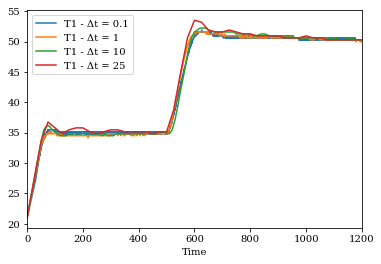

In [349]:
pos_dt_01 = pandas.read_csv('Position_sample_rate_0.1.csv').set_index('Time')
pos_dt_1 = pandas.read_csv('Position_sample_rate_1.csv').set_index('Time')
pos_dt_5 = pandas.read_csv('Position_sample_rate_5.csv').set_index('Time')
pos_dt_10 = pandas.read_csv('Position_sample_rate_10.csv').set_index('Time')
pos_dt_25 = pandas.read_csv('Position_sample_rate_25.csv').set_index('Time')

fig, (axtemp) = plt.subplots(1)
pos_dt_01[['T1']].rename(columns={'T1': 'T1 - Δt = 0.1'}).plot(ax=axtemp)
pos_dt_1[['T1']].rename(columns={'T1': 'T1 - Δt = 1'}).plot(ax=axtemp)
# pos_dt_5[['T1']].rename(columns={'T1': 'T1 - Δt = 5'}).plot(ax=axtemp)
pos_dt_10[['T1']].rename(columns={'T1': 'T1 - Δt = 10'}).plot(ax=axtemp)
pos_dt_25[['T1']].rename(columns={'T1': 'T1 - Δt = 25'}).plot(ax=axtemp)

# pos_dt_01[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 0.1'}).plot(ax=axheat)
# pos_dt_1[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 1'}).plot(ax=axheat)
# pos_dt_5[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 5'}).plot(ax=axheat)
# pos_dt_10[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 10'}).plot(ax=axheat)
# pos_dt_25[['Q1']].rename(columns={'Q1': 'Q1 - Δt = 25'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Position_sample_rate.pdf', format='pdf')

# Linearity

In [15]:
def set_point(t, set_points, duration_of_each_steady):
    time_list = np.arange(0, duration_of_each_steady*len(set_points), duration_of_each_steady)
    
    counter = len(set_points) - 1
    while t<time_list[counter]:
        counter-=1
    return set_points[counter]

def disturbance(t):
    if t < 800:
        return 0
    else:
        return 0

In [16]:
set_points = [10, 50, 90]
duration_of_each_steady = 1000
set_points_list = []

#### Position linearity

In [17]:
def position_form_linearity(Kc, τI, τD, Δt, connect, tspan, controller, filename):  
    
    TCLab = tclab.setup(connected=connect, speedup=100)
    with TCLab() as lab:
        h = tclab.Historian(lab.sources)
        plot = tclab.Plotter(h, tspan)
        
        esum, ek_1, ek = 0, 0, 0
        
        if controller == 'PID':
            for t in tclab.clock(tspan+200, step=Δt):
                setpoint = set_point(t, set_points, duration_of_each_steady)
                bias = (setpoint - 25)/0.85
                ek = setpoint - lab.T1
                esum += ek
                pk = bias + Kc*(ek + (Δt/τI)*esum + (τD/Δt)*(ek - ek_1))
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
       
        elif controller == 'PI':
            for t in tclab.clock(tspan+200, step=Δt):
                setpoint = set_point(t, set_points, duration_of_each_steady)
                bias = (setpoint - 25)/0.85
                ek = setpoint - lab.T1
                esum += ek
                pk = bias + Kc*(ek + (Δt/τI)*esum)
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
        
        elif controller == 'P':
            for t in tclab.clock(tspan+200, step=Δt):
                setpoint = set_point(t, set_points, duration_of_each_steady)
                bias = (setpoint - 25)/0.85
                ek = setpoint - lab.T1
                esum += ek
                pk = bias + Kc*(ek)
                ek_1 = ek
                lab.Q2(disturbance(t))
                lab.Q1(pk)

                plot.update(t)
                lab.update(t) 
       
        h.to_csv(filename)

#### Velocity Linearity

In [18]:
def velocity_form_linearity(Kc, τI, τD, Δt, connect, tspan, controller, filename):  
    
    TCLab = tclab.setup(connected=connect, speedup = 100)
    with TCLab() as lab:
        h = tclab.Historian(lab.sources)
        plot = tclab.Plotter(h, tspan)
        
        ek = ek_1 = ek_2 = 0
        if controller == 'PID':
            for t in tclab.clock(tspan+200, step=Δt):
                setpoint = set_point(t, set_points, duration_of_each_steady)
                bias = (setpoint - 25)/0.85
                ek = setpoint - lab.T1

                Δpk = Kc*((ek - ek_1) + (Δt/τI)*ek + (τD/Δt)*(ek - 2*ek_1 + ek_2))
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
        if controller == 'PI':
            for t in tclab.clock(tspan+200, step=Δt):
                setpoint = set_point(t, set_points, duration_of_each_steady)
                bias = (setpoint - 25)/0.85
                ek = setpoint - lab.T1

                Δpk = Kc*((ek - ek_1) + (Δt/τI)*ek)
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
        if controller == 'P':
            for t in tclab.clock(tspan+200, step=Δt):
                setpoint = set_point(t, set_points, duration_of_each_steady)
                bias = (setpoint - 25)/0.85
                ek = setpoint - lab.T1

                Δpk = Kc*((ek - ek_1))
                
                lab.Q2(disturbance(t))
                lab.Q1(Δpk + lab.Q1()) #Here we implement readback, we basically adding pk-2 term to the current time \Deltapk

                ek_2 = ek_1
                ek_1 = ek

                plot.update(t)
            
    h.to_csv(filename)

#### Continuous Linearity

In [19]:
def continuous_linearity(Kc, tau_i, tau_d, alpha, tspan, controllertype, filename):
    if 'I' in controllertype:
        Gc = Kc*(1 + 1/(tau_i*s) + tau_d*s/(alpha*tau_d*s + 1))
    else:
        Gc = Kc*(1 + tau_d*s/(alpha*tau_d*s + 1))    

    # simulate zero-error run to get initial state vector
    T, yout, xout = control.forced_response(Gc, [0, 1], None, transpose=True)

    # get initial state vector
    xc = xout[-1]

    steptime = 1
    totaltime = tspan + 200

    times = np.arange(0, totaltime, steptime)

    with tclab.TCLabModel(synced=False) as lab:  # change to TCLab for real
        historian = tclab.Historian(lab.sources)

        prev_t = 0

        error = set_point(0, set_points, duration_of_each_steady) - lab.T1

        for t in tqdm(times):  # change to tclab.clock(steptime=steptime) to sync with time
            # Figure out how much time has gone by since previous clock tick
            # Note in the simulation case this will always be `steptime`, but when we sync
            # it may not be, so we have to calculate correctly
            setpoint = set_point(t, set_points, duration_of_each_steady)
            set_points_list.append(setpoint)
            Δt = t - prev_t
            prev_t = t
            bias = (setpoint - 25)/0.85

            # integrate controller assuming error stays constant over timestep (zero-order-hold)
            # notice we're using the error from the previous time step, 
            # because we're simulating from one step ago to right now.
            _, yout, xout = control.forced_response(Gc, [0, Δt], [error, error], xc, transpose=True)

            controller_output = yout[-1]  + bias
            xc = xout[-1]

            # communicate with tclab
            # We read the error at "the same time" as we write
            # This ensures that the controller uses only information from the previous time step
            error = setpoint - lab.T1

            # write out to tclab
            lab.Q2(disturbance(t))
            lab.Q1(controller_output)

            # update historian
            historian.update(t)
            lab.update(t)  # for the real lab this is not required

    historian.to_csv(filename)

In [ ]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 2800
position_form_linearity(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'Position_linearity.csv')

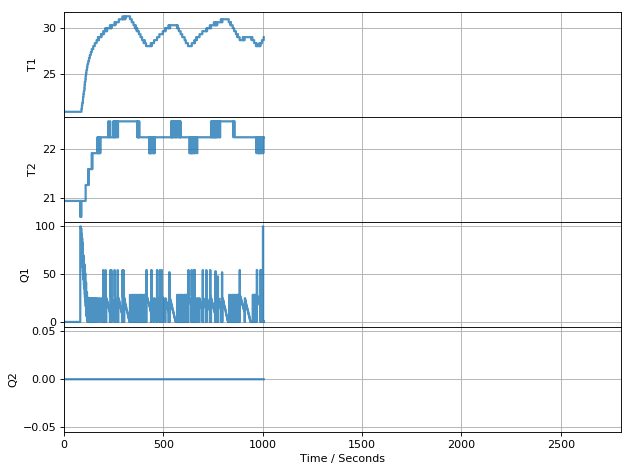

In [ ]:
Kc = 11.01
τ_I = 207.34
τ_d = 7.29
Δt = 1
tspan = 2800
velocity_form_linearity(Kc, τ_I, τ_d, Δt, False, tspan, 'PID', 'Velocity_linearity.csv')

In [ ]:
Kc = 11.01
tau_i = 207.34
tau_d = 7.29
alpha = 0.1
tspan = 2800
continuous_linearity(Kc, tau_i, tau_d, alpha, tspan, 'PID', 'Continuous_linearity.csv')

In [ ]:
pos_lin = pandas.read_csv('Position_linearity.csv').set_index('Time')
vf_lin = pandas.read_csv('Velocity_linearity.csv').set_index('Time')
cont_lin = pandas.read_csv('Continuous_linearity.csv').set_index('Time')
cont_sp_time = pandas.read_csv('Continuous_linearity.csv')

fig, (axtemp, axheat) = plt.subplots(2, 1)
axtemp.plot(cont_sp_time[['Time']], set_points_list)
pos_lin[['T1']].rename(columns={'T1': 'T1 - Position form'}).plot(ax=axtemp)
vf_lin[['T1']].rename(columns={'T1': 'T1 - Velocity form'}).plot(ax=axtemp)
cont_lin[['T1']].rename(columns={'T1': 'T1 - Continuous'}).plot(ax=axtemp)

pos_lin[['Q1']].rename(columns={'Q1': 'Q1 - Position form'}).plot(ax=axheat)
vf_lin[['Q1']].rename(columns={'Q1': 'Q1 - Velocity form'}).plot(ax=axheat)
cont_lin[['Q1']].rename(columns={'Q1': 'Q1 - Continuous'}).plot(ax=axheat)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('Linearity.pdf', format='pdf')

# IMC vs Continuous PID

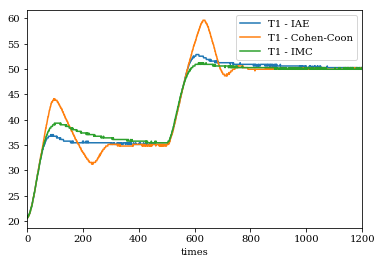

In [354]:
IAE_PID_cont = pandas.read_csv('cont_IAE_PID.csv').set_index('Time')
CC_PID_cont = pandas.read_csv('cont_CC_PID.csv').set_index('Time')
IMC = pandas.read_csv('cont_IMC 500.csv').set_index('times')

fig, (axtemp) = plt.subplots(1)
IAE_PID_cont[['T1']].rename(columns={'T1': 'T1 - IAE'}).plot(ax=axtemp)
CC_PID_cont[['T1']].rename(columns={'T1': 'T1 - Cohen-Coon'}).plot(ax=axtemp)
IMC[['true_values']].rename(columns={'true_values': 'T1 - IMC'}).plot(ax=axtemp)

rc("text", usetex=False)
rc("font", family="serif")
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
plt.savefig('IMC_vs_cont_PID.pdf', format='pdf')